# Checkpoint 2: Mandatory Check-In

- Research Questions (1.5%).
- Feature Engineering (2%).
- Modeling Approaches (3%).
- Preliminary Results (1%).


In [1]:
import zipfile
import numpy as np
import re
import io
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import read_files_from_zip, data2pd, show_balance
from feature_utils import crop_and_fill
from eda_utils import show_image


#%load_ext memory_profiler
#from importlib import reload
#reload(data_utils)

## Import data

In [14]:
%%time

# Set Date Source
data_file = '../Data/sp24_grad_project_data.zip'

# Load Test Images
test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')

# Load Train Images and Labels
train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')

# Convert to Dataframe
train_df = data2pd(train_data_images, train_data_labels)
test_df = data2pd(test_data_images)

# Clean up
del(test_data_images)
del(train_data_images)
del(train_data_labels)

Importing data from zip: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Found the following datasets:  ['hurricane-matthew', 'flooding-fire']


Importing data from zip: 100%|██████████| 3/3 [00:12<00:00,  4.17s/it]


Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


Importing data from zip: 100%|██████████| 3/3 [00:00<00:00, 1896.73it/s]

Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']
CPU times: user 14.4 s, sys: 942 ms, total: 15.3 s
Wall time: 15.4 s


In [15]:
print('Train label balance:')
show_balance(train_df)

Train label balance:


type       label
fire       0        7204
           3        1064
           1          69
           2          43
flood      0        6734
           1         114
           2          97
           3          59
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

## Data Cleansing Plan

There are many potential enhancements, this seems a reasonable starting point.

 - Scale images to 180x180 (ResNet50 default)
 - Normalize pixel values from 0-255 to be float from 0-1
 - For Type Classifier, encode level+type to float between -1 and 1
 - For Level Classifier, ohe level to catagories 0-4
 - When undersampling, sample without replacement within innerquartile 
 - When oversampling, include entire set then sample with replacement and augmentation 


## Data split and augmentation plan (Disaster Type Classification)

We'll use a mix of oversampling and undersampling...

 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match
 - think about how to use Neighborhood Cleaning Under Sampling...
   
 - Validation:
     - Sample without replacement 8 samples of each disaster type/level
 - Training:
     - fire:3 has the most (1064-8) representation,
     - flood:1 the next largest (114-8) representation and
     - fire:2 has the least (43-8).

In [16]:
# Feature Engineering

# Add a size column
def get_size(img):
    dim = img.shape
    return dim[0] * dim[1]
train_df['size'] = train_df['image'].apply(get_size)

# Show size feature and range
print(train_df.columns)
train_df[['size']].describe().T

Index(['index', 'type', 'image', 'label', 'size'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
size,26535.0,8169.871867,12364.717747,84.0,1936.0,4340.0,10240.0,410464.0


In [12]:
# Create dataset for Disaster Type Classification
classify_type_df = train_df[(train_df.type == 'fire') | (train_df.type == 'flood')]
show_balance(classify_type_df)
classify_type_df.shape

type   label
fire   1        150
       2        150
       3        150
       0         75
flood  1        150
       2        150
       3        150
       0         75
Name: count, dtype: int64

(1050, 5)

In [17]:
# Create validation set for modelling.

# We would like for our test set to representive of our population so...
# we'll limit it sizes in the innerquartile.
#
# Also, since we don't have must data we want to lose as litte as possible...
# so, we do our validataion k-folds manually.
#
# We're also selecting only samples that have sizes within the 
# innerquartile to choose the 'most' representative.

def get_validation_set(classify_type_df):
    sample_size = 8
    
    classify_type_valid_df = pd.DataFrame()
    print('Before: ',classify_type_df.shape)
    for T in classify_type_df.type.unique():
        for L in classify_type_df.label.unique():
            if (L==0):
                this_sample_size = sample_size//2
            else:
                this_sample_size = sample_size
            sample_df =  classify_type_df[
                    (classify_type_df['type'] == T) & (classify_type_df['label'] == L)
                    & ((classify_type_df['size'] <= 10240) & (classify_type_df['size'] >= 1936)) 
                ].sample(this_sample_size)
            classify_type_valid_df = pd.concat([sample_df, classify_type_valid_df])
    classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)
    return classify_type_valid_df, classify_type_df

# We know emperically that there are only two unique validation splits
# that statisfy our requirements.

classify_type_valid_df = []
residue_df = classify_type_df
for i in range(2): 
    tmp_df, residue_df = get_validation_set(residue_df)
    classify_type_valid_df.append(tmp_df)
    show_balance(classify_type_valid_df[i])

Before:  (1050, 5)


type   label
fire   1        8
       2        8
       3        8
       0        4
flood  1        8
       2        8
       3        8
       0        4
Name: count, dtype: int64

Before:  (938, 5)


type   label
fire   1        8
       2        8
       3        8
       0        4
flood  1        8
       2        8
       3        8
       0        4
Name: count, dtype: int64

In [18]:
from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

def get_validation_set(classify_type_df, classify_type_valid_df):
    classify_type_train_df = pd.DataFrame()

    # Drop the validation set before sampling
    classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)
    
    # Set a reasonable argumentation limit
    sample_size = 150 #int(114 * 1.32)
    
    # We apply flip, rotate augmentation to the
    # sample with replacement samples.
    # We might duplicate an augmentation if the
    # same record is sampled and the augmentation
    # is applied.
    # Anyway... Cool thing is that we can get as many unique
    # balanced training sets as we desire.
    
    for T in classify_type_df.type.unique():
        for L in classify_type_df.label.unique():
            if L==0:
                this_sample_size = sample_size//2
            else:
                this_sample_size = sample_size
            record_size = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].shape[0]
            if (record_size > this_sample_size):
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size)
            else:
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)]
                classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size-record_size, replace=True)
                sample_df['image'] = sample_df['image'].apply(augment_image)
            classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
    return classify_type_train_df

# We are trying to squeeze out as much unique data as possible...
# because there isn't much to work with.
classify_type_train_df = []
for i in range(2):
    tmp_df = get_validation_set(classify_type_df, classify_type_valid_df[i])
    classify_type_train_df.append(tmp_df)
    show_balance(classify_type_train_df[i])

type   label
fire   1        150
       2        150
       3        150
       0         75
flood  1        150
       2        150
       3        150
       0         75
Name: count, dtype: int64

type   label
fire   1        150
       2        150
       3        150
       0         75
flood  1        150
       2        150
       3        150
       0         75
Name: count, dtype: int64

## Data split and augmentation plan (Disaster Level Classification)

We'll use a mix of oversampling and undersampling...
 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match

 - Validation:
    - Sample without replacement N samples of each disaster level
 - Training:
    - Select a sample size such that is a balance between drop/augment

In [19]:
# Create dataset for Disaster Type Classification

# This dataset is a bit more balanced.
classify_level_df = train_df[(train_df.type == 'hurricane')]
show_balance(classify_level_df)

type       label
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

In [20]:
# Find a good validation split size
# We'll pick a whole number for our puny human brains.
validation_sample_size = int(classify_level_df.groupby('type')['label'].value_counts().min() * .1945)
print(validation_sample_size)

300


In [21]:
# Find a good augmentation size
# We'll pick a whole number for our puny human brains.
augmentation_size = int(classify_level_df.groupby('type')['label'].value_counts().min() * 1.2955)
print(augmentation_size)

2000


In [22]:
# Create validation set for modelling.

# We would like for our test set to representive
# of our population so we'll limit it
# sizes in the innerquartile.
classify_level_valid_df = pd.DataFrame()
print('Before: ',classify_level_df.shape)
for T in classify_level_df.type.unique():
    for L in classify_level_df.label.unique():
        #print(f'{T}:{L}')
        sample_df =  classify_level_df[(classify_level_df['type'] == T) & (classify_level_df['label'] == L)
        & ((classify_level_df['size'] <= 10240) & (classify_level_df['size'] >= 1936)) 
        ].sample(validation_sample_size)
        #display(sample_df.shape)
        #print(type(sample_df))
        classify_level_valid_df = pd.concat([sample_df, classify_level_valid_df])
# drop our test sample from the parent df
classify_level_df = classify_level_df.drop(index=classify_level_valid_df.index)       

print('After: ',classify_level_df.shape)

assert(9951 == classify_level_df.shape[0]), 'Invalid parent data size, something looks fishy.'

Before:  (11151, 5)
After:  (9951, 5)


In [23]:
from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

classify_level_train_df = pd.DataFrame()

# Set a reasonable argumentation limit
sample_size = augmentation_size

# We apply flip, rotate augmentation to the
# sample with replacement samples.
# We might duplicate an augmentation if the
# same record is sampled and the augmentation
# is applied.
# Anyway... Cool thing is that we can get as many unique
# balanced training sets as we desire.

for T in classify_level_df.type.unique():
    for L in classify_level_df.label.unique():
        record_size = classify_level_df[
        (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].shape[0]
        if (record_size > sample_size):
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].sample(sample_size)
        else:
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)]
            classify_level_train_df = pd.concat([sample_df, classify_level_train_df])
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].sample(
                sample_size-record_size, replace=True)
            sample_df['image'] = sample_df['image'].apply(augment_image)
        classify_level_train_df = pd.concat([sample_df, classify_level_train_df])
count_s = classify_level_train_df.groupby('type')['label'].value_counts()
display(count_s)

type       label
hurricane  0        2000
           1        2000
           2        2000
           3        2000
Name: count, dtype: int64

In [24]:
# Now let's recap our datasets for task B
show_balance(classify_level_valid_df)
show_balance(classify_level_train_df)

type       label
hurricane  0        300
           1        300
           2        300
           3        300
Name: count, dtype: int64

type       label
hurricane  0        2000
           1        2000
           2        2000
           3        2000
Name: count, dtype: int64

In [ ]:
300/2000

---

## Feature Engineering

Recall our Tasks:

**Disaster Type Classification**
 -  The goal is to build a classifier that can automatically categorize images based on the type of disaster scenario, such as flooding or fire.
   
**Damage Level Classification**
 - The objective is to create a classifier that can automatically determine the level of building damage following a disaster, specifically for hurricanes.

For now we've only added size and used it for undersampling.
These are images so we'll let Gauss do his thing...
...try not to second guess Gauss.


## Modelling

Let's cookup a the simplest model we can think of...
For us this a autoencoder where we encoding our convolved image into a latent space then decode to our classes.

**Task A**
 - Reshape (180x180, normalize for positive definteness)
 - Conv2d (180x180)
 - MaxPooling2D (60x60, Dense, ReLu)
 - Dropout
 - Flatten
 - Dense (10 classes) flood or fire and levels 0-3

**Task B**
 - Reshape ((180x180, normalize for positive definteness)
 - Conv2d (180x180)
 - MaxPooling2D (60x60, Dense, ReLu)
 - Dropout
 - Flatten
 - Dense (4 classes) levels 0-3

Consider augment the data with 0-45 degree rotataton and 100to120% scaling.

In [26]:
# Recall our datasets

for i in range(2):
    print(len(classify_type_valid_df[i]), len(classify_type_train_df[i]))
    
print(len(classify_level_valid_df), len(classify_level_train_df))

56 1050
56 1050
1200 8000


In [40]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

2024-03-29 12:37:09.899100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# Encode Labels
import cv2


"""
classify_type_valid_df['type_code'] = classify_type_valid_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
classify_type_train_df['type_code'] = classify_type_train_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)

classify_type_valid_df['type_code'] = classify_type_valid_df['type_code']/classify_type_valid_df['type_code'].abs().max()
classify_type_train_df['type_code'] = classify_type_train_df['type_code']/classify_type_train_df['type_code'].abs().max()

X_train = classify_type_train_df['image'].to_list()
Y_train = classify_type_train_df['type_code']

X_valid = classify_type_valid_df['image'].to_list()
Y_valid = classify_type_valid_df['type_code']



X_train = np.array([cv2.resize(img, (180, 180)) for img in X_train])
X_valid = np.array([cv2.resize(img, (180, 180)) for img in X_valid])
"""
def encode_type(type_df):
    # -1:flood, +1:fire
    type_df['type_code'] = type_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
    type_df['type_code'] = type_df['type_code']/type_df['type_code'].abs().max()
    X = type_df['image'].to_list()
    X = np.array([cv2.resize(img, (180, 180)) for img in X])
    Y = type_df['type_code']
    return X,Y

X_valid, Y_valid = [], []
X_train, Y_train = [], []

for i in range(2):
    X_valid_tmp, Y_valid_tmp = encode_type(classify_type_valid_df[0])
    X_train_tmp, Y_train_tmp = encode_type(classify_type_train_df[0])
    X_valid.append(X_valid_tmp)
    Y_valid.append(Y_valid_tmp)
    X_train.append(X_train_tmp)
    Y_train.append(Y_train_tmp)

In [37]:
len(X_train[0]), Y_train[0].shape, len(X_train[1]), Y_train[1].shape

(1050, (1050,), 1050, (1050,))

In [47]:
backend.clear_session()  # clear model 

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects

# Define our custom activation function
def custom_activation(y):
    return tf.where(y > 0, 1, 0)

# Get the custom activation function
# Not required if we keep activation outside of model
# get_custom_objects().update({'custom_activation': layers.Activation(custom_activation)}) 

# Define the model
model = Sequential([
    # Rescaling layer
    layers.Rescaling(1./255, input_shape=(None, None, 3)),
    
    # Resize layer
    layers.Resizing(180, 180),
    
    # Conv2D layer (1st)
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),
    
    # Dropout layer
    layers.Dropout(0.2),

    # Conv2D layer (2nd)
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),
    
    # Dropout layer
    layers.Dropout(0.2),

    # Conv2D layer (3rd)
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),
    
    # Dropout layer
    layers.Dropout(0.2),
    
    
    # Flatten layer
    layers.Flatten(),
    
    # Dense layer with linear activation for regression
    layers.Dense(1, activation='linear')
])

# Add in our custom activation layer
# Nope... we want to keep this outside of the model...
#model.add(layers.Activation(custom_activation))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')  # w/o custom layer
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Nope

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 89, 89, 64)        2112      
                                                                 
 dropout (Dropout)           (None, 89, 89, 64)        0         
                                                        

In [61]:
# While we created two splits of the data it
# cause some major overfitting problems, so
# we'll train with just one.
# We're getting 95% across the board as it, so well be fine.  ;-)

model_history = model.fit(X_train[0], Y_train[0],
                      validation_data = (X_valid[0], Y_valid[0]),
                      epochs=20, batch_size=132,
                      verbose = 1) # 

Epoch 1/20
8/8 [==============================] - 50s 6s/step - loss: 0.1451 - val_loss: 0.1497
Epoch 2/20
8/8 [==============================] - 49s 6s/step - loss: 0.1260 - val_loss: 0.1588
Epoch 3/20
8/8 [==============================] - 51s 6s/step - loss: 0.1160 - val_loss: 0.1369
Epoch 4/20
8/8 [==============================] - 53s 7s/step - loss: 0.1127 - val_loss: 0.1302
Epoch 5/20
8/8 [==============================] - 52s 7s/step - loss: 0.1119 - val_loss: 0.1374
Epoch 6/20
8/8 [==============================] - 52s 7s/step - loss: 0.1105 - val_loss: 0.1389
Epoch 7/20
8/8 [==============================] - 52s 7s/step - loss: 0.1073 - val_loss: 0.1294
Epoch 8/20
8/8 [==============================] - 51s 6s/step - loss: 0.1074 - val_loss: 0.1322
Epoch 9/20
8/8 [==============================] - 51s 6s/step - loss: 0.1045 - val_loss: 0.1303
Epoch 10/20
8/8 [==============================] - 50s 6s/step - loss: 0.1041 - val_loss: 0.1326
Epoch 11/20
8/8 [======================

In [76]:
def custom_activation(x):
    return tf.where(x >= 0, 1, 0)

prediction = model.predict(X_valid[1])
prediction = tf.squeeze(custom_activation(prediction)) # sometimes to just want to hug a squeeze your tensors
actual = custom_activation(Y_valid[1])

2/2 [==============================] - 1s 301ms/step


In [77]:
prediction, actual # visually this looks pretty good

(<tf.Tensor: shape=(56,), dtype=int32, numpy=
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], dtype=int32)>,
 <tf.Tensor: shape=(56,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>)

In [78]:
np.sum(prediction==0,axis=0), np.sum(prediction==1,axis=0) # nice an balances

(25, 31)

In [79]:
# remember our activation is greater than zero,
# thus we have 8 more zero values, as expected.
np.sum(actual==0,axis=0), np.sum(actual==1,axis=0) 

(24, 32)

In [80]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history["loss"], label = "train_loss", ls = '--')
    plt.plot(np.arange(0, N), history["val_loss"], label = "val_loss", ls = '--')
    plt.yscale('log')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

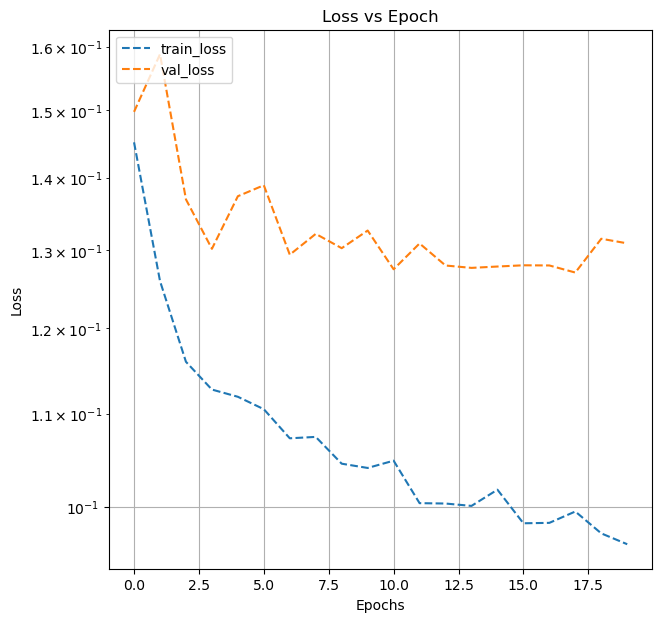

In [81]:
plot_loss(model_history)

In [82]:
model_history.history

{'loss': [0.145144984126091,
  0.1259644478559494,
  0.11598270386457443,
  0.11273834109306335,
  0.11190943419933319,
  0.11049861460924149,
  0.10725978016853333,
  0.10741430521011353,
  0.10451320558786392,
  0.10405810177326202,
  0.10483407974243164,
  0.10038083791732788,
  0.100342757999897,
  0.10010021179914474,
  0.10177230089902878,
  0.09833823144435883,
  0.09838013350963593,
  0.09952846169471741,
  0.09732745587825775,
  0.09625565260648727],
 'val_loss': [0.14973923563957214,
  0.15882229804992676,
  0.13692304491996765,
  0.13017943501472473,
  0.1373695731163025,
  0.13891592621803284,
  0.129397913813591,
  0.13218332827091217,
  0.1302625983953476,
  0.1326332539319992,
  0.12748539447784424,
  0.13089479506015778,
  0.1279771775007248,
  0.12766693532466888,
  0.12784399092197418,
  0.1280055195093155,
  0.12798334658145905,
  0.12705965340137482,
  0.1315232217311859,
  0.13090960681438446]}

              precision    recall  f1-score   support

           0     0.8000    0.8333    0.8163        24
           1     0.8710    0.8438    0.8571        32

    accuracy                         0.8393        56
   macro avg     0.8355    0.8385    0.8367        56
weighted avg     0.8406    0.8393    0.8397        56



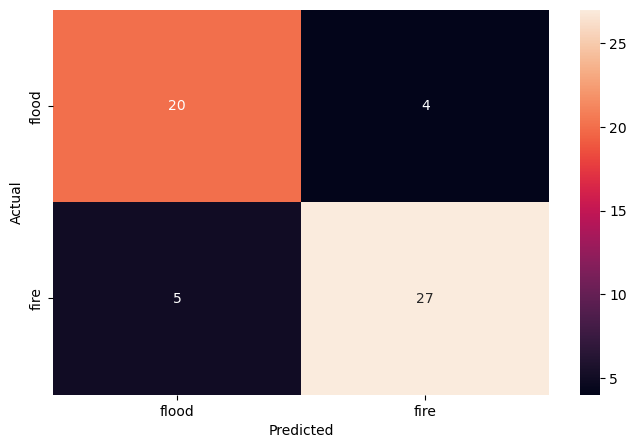

In [83]:
# Evaluate our model based on precision, recall, and f1-score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(actual, prediction, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [70]:
# Create dataset for Disaster Type Classification
actual_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood')) & (train_df.label != 0)].copy()
show_balance(actual_df)

type   label
fire   3        1064
       1          69
       2          43
flood  1         114
       2          97
       3          59
Name: count, dtype: int64

In [71]:
# -1:flood, +1:fire
actual_df['type_code'] = actual_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
actual_df['type_code'] = actual_df['type_code']/actual_df['type_code'].abs().max()

X_actual = actual_df['image'].to_list()
X_actual = np.array([cv2.resize(img, (180, 180)) for img in X_actual])
Y_actual = actual_df['type_code']

In [72]:
prediction = model.predict(X_actual)
prediction = tf.squeeze(custom_activation(prediction)) # give the tensor a hug and squeeze
actual = custom_activation(Y_actual)

46/46 [==============================] - 18s 385ms/step


              precision    recall  f1-score   support

           0     0.9237    0.8519    0.8863       270
           1     0.9666    0.9838    0.9751      1176

    accuracy                         0.9592      1446
   macro avg     0.9451    0.9178    0.9307      1446
weighted avg     0.9586    0.9592    0.9586      1446



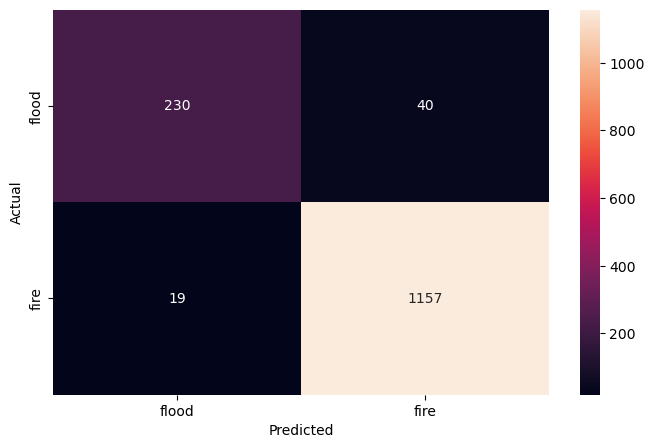

In [73]:
# Evaluate our model based on precision, recall, and f1-score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(actual, prediction, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model.summary() 

In [ ]:
43//8 # unique validation splits

## Notes and Resources

https://learningds.org/ch/19/class_pred.html

https://neptune.ai/blog/keras-loss-functions

https://www.h2kinfosys.com/blog/linear-classifier-with-tensorflow-keras/


In [84]:
50*20/60 * 8 # estimated runtime of mobel B on cpu... don't got time for that

133.33333333333334